In [1]:
import pandas as pd
import numpy as np

#Importing food dataset and converting to pandas Series using pd.read_csv
df1= pd.read_csv(r'C:\Users\acer\AICW\food.csv')
df1.columns=['food_id','name','resturant_id','price','orders_num','category','avg_rating','num_rating','tag']
df1

#


,food_id,name,resturant_id,price,orders_num,category,avg_rating,num_rating,tag
0,1,Veg Momo,1,150,20,momo,4.0,10,"veg,healthy"
1,2,Chicken Momo,1,180,40,momo,4.5,12,"chicken,healthy"
2,3,Buff Momo,1,160,50,momo,4.6,30,"buff,healthy"
3,4,Paneer Momo,1,200,15,momo,3.2,6,"paneer,healthy"
4,5,Mutton Momo,1,210,18,momo,3.0,8,"mutton,healthy"
5,6,Buff Choila,1,140,30,newari,2.1,10,"buff,spicy"
6,7,Mutton Choila,1,130,35,newari,4.9,21,"mutton,spicy"
7,8,Sadheko Choila,1,215,55,newari,2.0,44,"sadheko,spicy"
8,9,Buff Kachela,1,205,8,newari,3.6,2,"buff,spicy"
9,10,Bhatmas Sadeko,1,85,3,newari,3.9,1,"bhatmas,sour"


In [2]:
#Demographic Filtering
#Use True Bayesian Estimate 

# Calculating mean of average rating across all the items
C= df1['avg_rating'].mean()

# Calculate minimum number of votes required for food items to appear in the recommendation for the user i.e.50th percentile amongst num_rating
m= df1['num_rating'].quantile(0.5)

#Calculating items that qualify for minimum number of votes and copying it with deep=true
quali_items=df1.copy().loc[df1['num_rating'] >= m]
quali_items.shape



(6, 9)

In [3]:

quali_items
#df1['num_rating']>=m


,food_id,name,resturant_id,price,orders_num,category,avg_rating,num_rating,tag
0,1,Veg Momo,1,150,20,momo,4.0,10,"veg,healthy"
1,2,Chicken Momo,1,180,40,momo,4.5,12,"chicken,healthy"
2,3,Buff Momo,1,160,50,momo,4.6,30,"buff,healthy"
5,6,Buff Choila,1,140,30,newari,2.1,10,"buff,spicy"
6,7,Mutton Choila,1,130,35,newari,4.9,21,"mutton,spicy"
7,8,Sadheko Choila,1,215,55,newari,2.0,44,"sadheko,spicy"


In [4]:
# Calculation of True Bayesian Estimate(Weighted Rating)
def bayes_estim(x, m=m, C=C):
    v= x['num_rating']
    R= x['avg_rating']
    return (v/(v+m) *R) + (m/(m+v) *C)

#Create feature named points and apply the weighted rating to qualified item DataFrame 
quali_items['points']= quali_items.apply(bayes_estim, axis=1)

#Sort the qualified items in decending order according to required features 
# Display top_rated_items and sort 'points' in decending order 
# Display popular_items and sort 'orders_num' in descending order

top_rated_items= quali_items.sort_values('points', ascending=False)
popular_items= quali_items.sort_values('orders_num', ascending= False)

# Display items of top_rated_items and use [[]] to convert to pandas Dataframe 

popular_items[['name','category','num_rating', 'avg_rating','orders_num' ]].head()

  
    

,name,category,num_rating,avg_rating,orders_num
7,Sadheko Choila,newari,44,2.0,55
2,Buff Momo,momo,30,4.6,50
1,Chicken Momo,momo,12,4.5,40
6,Mutton Choila,newari,21,4.9,35
5,Buff Choila,newari,10,2.1,30


In [5]:
top_rated_items[['name','category','num_rating','avg_rating','points']].head()

,name,category,num_rating,avg_rating,points
6,Mutton Choila,newari,21,4.9,4.474194
2,Buff Momo,momo,30,4.6,4.345000
1,Chicken Momo,momo,12,4.5,4.081818
0,Veg Momo,momo,10,4.0,3.790000
5,Buff Choila,newari,10,2.1,2.840000


Text(0.5, 1.0, 'Popular Food items')

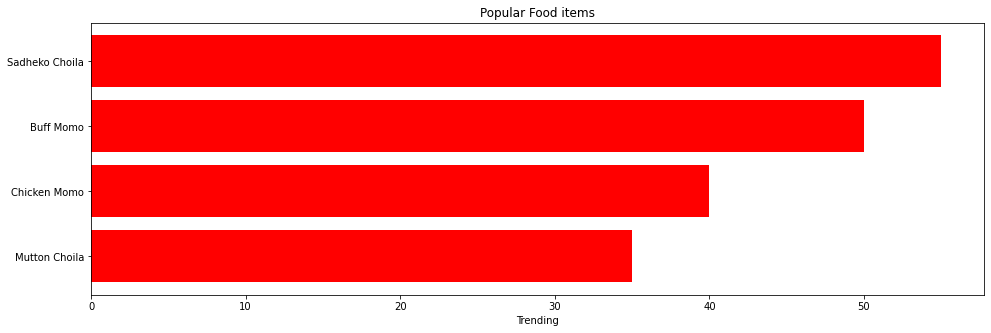

In [6]:
# Horizontal Bar chart of Popular Items

import matplotlib.pyplot as pl
pl.figure(figsize=(16,5))
pl.barh(popular_items['name'].head(4), popular_items['orders_num'].head(4), align='center', color='red')
pl.gca().invert_yaxis()
pl.xlabel('Trending')
pl.title('Popular Food items')

In [7]:
# Create a preprocessed string named combination by combining tag, name and category
# use set() to create a set of unique letters in string and join() to join letter backs in orginal order 

def comb_tag(x):            
    tag = x['tag'].lower().split(',')
    tag.extend(x['name'].lower().split())
    tag.extend(x['category'].lower().split())
    return " ".join(sorted(set(tag), key=lambda e: tag.index(e)))

df1['combination'] = df1.apply(comb_tag, axis=1)
df1.head()

                

,food_id,name,resturant_id,price,orders_num,category,avg_rating,num_rating,tag,combination
0,1,Veg Momo,1,150,20,momo,4.0,10,"veg,healthy",veg healthy momo
1,2,Chicken Momo,1,180,40,momo,4.5,12,"chicken,healthy",chicken healthy momo
2,3,Buff Momo,1,160,50,momo,4.6,30,"buff,healthy",buff healthy momo
3,4,Paneer Momo,1,200,15,momo,3.2,6,"paneer,healthy",paneer healthy momo
4,5,Mutton Momo,1,210,18,momo,3.0,8,"mutton,healthy",mutton healthy momo


In [16]:
#Import Count Vectorizer for Scikit-learn and create count matrix and mention stop_words to omit frequently occuring words
#Import Cosine Similarity 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

mtrx_count= CountVectorizer(stop_words="english")

# Creating a sparse matrix for our preprocessed string 
df_mtrx= mtrx_count.fit_transform(df1['combination'])


# Compouter pairwise similarity for df_mtrx
cosine_similarity_mtrx= cosine_similarity(df_mtrx,df_mtrx)

# For each food name or id we have to identify the index in out Dataframe 
# Use InverseMapping of Title and Indices 
indices_frm_name= pd.Series(df1.index, index=df1['name'])
indices_frm_food_indices= pd.Series(df1.index, index=df1['food_id'])

#Defining function to take food_id and name as input and compute similarity between them

def get_recommendation_gen(name='', cosine_similarity_mtrx=cosine_similarity_mtrx, idx=-1):

    #Getting index of the food item according to name i.e. food name
    if idx == -1 and name != '':
        idx = indices_frm_name[name]

        #Get pairwise cosine similarity of the selected food item with all other food items and converting into py tuple
        sim_cosne = list(enumerate(cosine_similarity_mtrx[idx]))

        #Sort the following tuple in descending order and ignore intial element aas it is element itself              
        sim_cosne = sorted(sim_cosne, key= lambda x: x[1], reverse=True)

        #Retirve list of 2 similar elements
        sim_cosne = sim_cosne[1:10]

        #Get food_indices
        food_indices = (i[0] for i in sim_cosne) 

        # Return top 5 most similar dishes 
        return food_indices
   

    











In [36]:
 df1.loc[get_recommendation_gen(name='Sadheko Choila')].head(3)



,food_id,name,resturant_id,price,orders_num,category,avg_rating,num_rating,tag,combination
5,6,Buff Choila,1,140,30,newari,2.1,10,"buff,spicy",buff spicy choila newari
6,7,Mutton Choila,1,130,35,newari,4.9,21,"mutton,spicy",mutton spicy choila newari
8,9,Buff Kachela,1,205,8,newari,3.6,2,"buff,spicy",buff spicy kachela newari
